In [1]:
#Biblio
import numpy as np
from skimage.io import imread
import time
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import skimage
from skimage import io as skio
import IPython
from skimage.transform import rescale
from skimage.io import imread
import sys


In [2]:

def noisegauss(im,br):
    """ Cette fonction ajoute un bruit blanc gaussier d'ecart type br
       a l'image im et renvoie le resultat"""
    imt=np.float32(im.copy())
    sh=imt.shape
    bruit=br*np.random.randn(*sh)
    imt=imt+bruit
    return imt

def viewimage(im, normalize=True,z=1,order=0,titre='',displayfilename=False):
    imin=im.copy().astype(np.float32)
    imin = rescale(imin, z, order=order)
    if normalize:
        imin-=imin.min()
        if imin.max()>0:
            imin/=imin.max()
    else:
        imin=imin.clip(0,255)/255 
    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))

def distpatch(patch1, patch2, khard=8):
    """
    Calcul distance entre deux patchs (sans seuillage).

    patch1, patch2: 1D arrays (flatten)
    """
    if patch1.size != patch2.size:
        print('Error: two patches should be in same size in function distpatch().\n')
        sys.exit()

    p1 = patch1.astype(np.float32)
    p2 = patch2.astype(np.float32)

    diff = p1 - p2
    dist = np.sqrt(np.sum(diff * diff)) / (khard ** 2)  # Normalization
    return dist


In [3]:
def nlm_patchwise(img, patch_size=3, search_window=21, h=0.4*15, sigma=15):
    """
    Implémentation patchwise du Non-Local Means.

    Args:
        img: Image en niveaux de gris (numpy array).
        patch_size: Taille des patches (doit être impair).
        search_window: Taille de la fenêtre de recherche (doit être impair).
        h: Paramètre de filtrage (ex: h = 0.4 * sigma).
        sigma: Écart-type du bruit.

    Returns:
        Image débruitée (numpy array).
    """
    # Initialisation
    half_patch = patch_size // 2
    half_search = search_window // 2
    accumulated_weights = np.zeros_like(img, dtype=np.float32)
    accumulated_values = np.zeros_like(img, dtype=np.float32)

    # Parcourir chaque pixel central d'un patch
    for i in range(half_patch, img.shape[0] - half_patch):
        for j in range(half_patch, img.shape[1] - half_patch):
            # Extraire le patch de référence
            patch = img[i-half_patch:i+half_patch+1, j-half_patch:j+half_patch+1]

            # Fenêtre de recherche
            i_start = max(i - half_search, half_patch)
            i_end = min(i + half_search, img.shape[0] - half_patch)
            j_start = max(j - half_search, half_patch)
            j_end = min(j + half_search, img.shape[1] - half_patch)

            # Initialisation pour le patch débruité
            weighted_patch_sum = np.zeros_like(patch, dtype=np.float32)
            weights_sum_patch = 0.0

            # Parcourir les patches voisins
            for k in range(i_start, i_end + 1):
                for l in range(j_start, j_end + 1):
                    k1, l1 = k - half_patch, l - half_patch
                    k2, l2 = k + half_patch, l + half_patch
                    neighbor_patch = img[k1:k2+1, l1:l2+1]

                    # Taille minimale pour normaliser la distance
                    h1, w1 = patch.shape
                    h2, w2 = neighbor_patch.shape
                    min_h, min_w = min(h1, h2), min(w1, w2)
                    min_size = min_h * min_w

                    # Calcul de la distance normalisée
                    diff = patch[:min_h, :min_w] - neighbor_patch[:min_h, :min_w]
                    dist = np.sum(diff**2) / min_size
                    weight = np.exp(-max(dist - 2*(sigma**2), 0) / (h**2))

                    weighted_patch_sum[:min_h, :min_w] += weight * neighbor_patch[:min_h, :min_w]
                    weights_sum_patch += weight
            # Estimation du patch débruité
            if weights_sum_patch > 0:
                denoised_patch = weighted_patch_sum / weights_sum_patch
            else:
                denoised_patch = patch  # Garde le patch original si aucun poids valide

            # Agrégation des estimations pour chaque pixel du patch
            for di in range(patch_size):
                for dj in range(patch_size):
                    pixel_i = i - half_patch + di
                    pixel_j = j - half_patch + dj
                    accumulated_weights[pixel_i, pixel_j] += 1.0
                    accumulated_values[pixel_i, pixel_j] += denoised_patch[di, dj]

    # Normalisation finale
    denoised_img = np.divide(
        accumulated_values,
        accumulated_weights,
        out=np.zeros_like(accumulated_values),
        where=accumulated_weights != 0
    )

    return np.clip(denoised_img, 0, 255).astype(np.uint8)



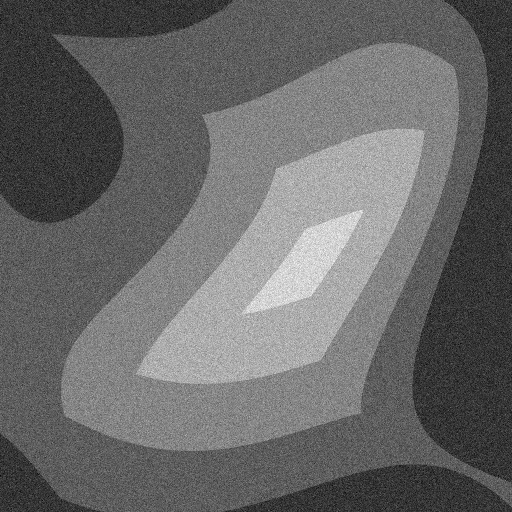

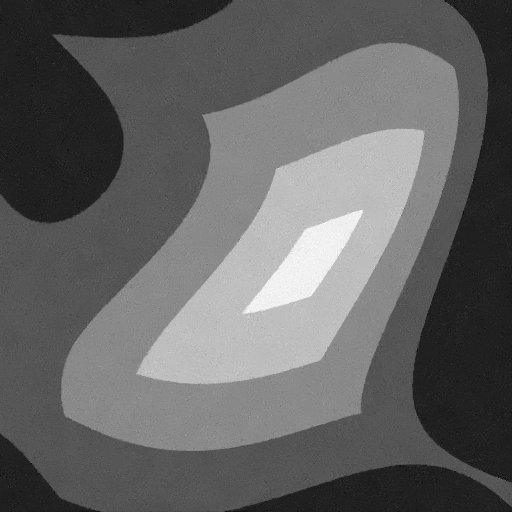

In [4]:
im=imread('img/pyramide.tif')
img=noisegauss(im,15)
viewimage(img,titre='Noisy Image',normalize=True)
denoised_img = nlm_patchwise(img, patch_size=3, search_window=21, h=0.4*15, sigma=15)
viewimage(denoised_img, titre='Denoised Image with Patchwise NLM', normalize=True)

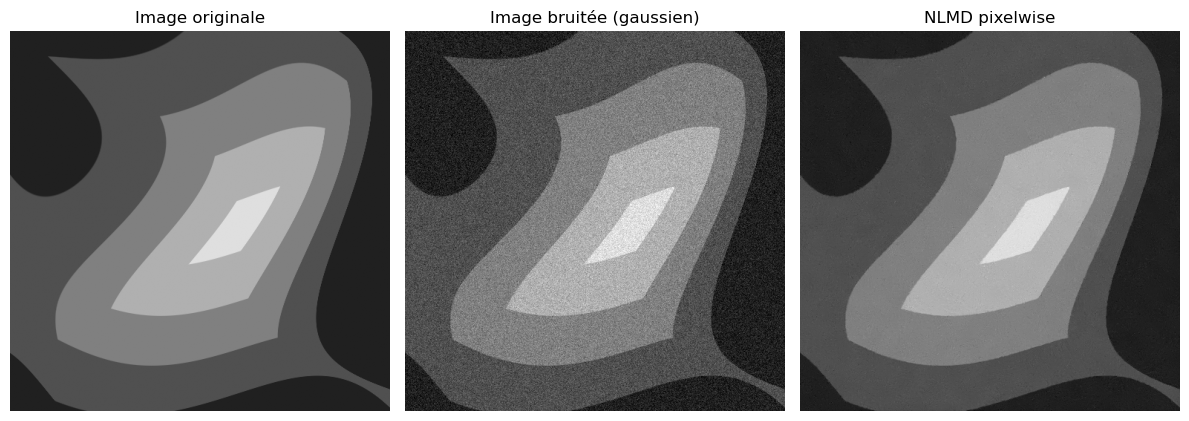

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 10))
ax = axes.ravel()
ax[0].imshow(im, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Image originale')
ax[1].imshow(img, cmap='gray', vmin=0, vmax=255)
ax[1].set_title('Image bruitée (gaussien)')
ax[2].imshow(denoised_img, cmap='gray', vmin=0, vmax=255)
ax[2].set_title('NLMD pixelwise')


for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()